Printed copies of *Elements of Data Science* are available now, with a **full color interior**.

From July 17 to July 31, [get 20% off at Lulu.com](https://www.lulu.com/shop/allen-downey/elements-of-data-science/paperback/product-9dyrwn.html).

# Resampling

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://raw.githubusercontent.com/AllenDowney/ElementsOfDataScience/v1/utils.py')

import utils

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ElementsOfDataScience/blob/v1/11_resampling.ipynb).

This chapter introduces **resampling methods**, which are used to quantify the precision of an estimate.
As a first example, we'll use results from a medical trial to estimate the efficacy of the vaccine.

## Vaccine Testing

Suppose you read a report about a new vaccine and the manufacturer says it is 67% effective at preventing disease.
You might wonder where that number comes from, what it means, and how confident we should be that it is correct.
Results like this often come from a randomized controlled trial (RCT), which works like this:

* You recruit a large group of volunteers and divide them into two groups at random: the "treatment group" receives the vaccine; the "control group" does not.

* Then you follow both groups for a period of time and record the number of people in each group who are diagnosed with the disease.

As an example, suppose you recruit 43,783 participants and they are assigned to groups with approximately the same size.

In [2]:
n_control = 21885
n_treatment = 21911

During the observation period, 468 people are diagnosed with the disease: 352 in the control group and 116 in the treatment group.

In [3]:
k_control = 352
k_treatment = 116

We can use these results to compute the risk of getting the disease for each group, in cases per 1000 people

In [4]:
risk_control = k_control / n_control * 1000
risk_control

16.084075851039522

In [5]:
risk_treatment = k_treatment / n_treatment * 1000
risk_treatment

5.294144493633334

The risk is substantially lower in the treatment group -- about 5 per 1000, compared to 16 -- which suggests that the vaccine is effective.
We can summarize these results by computing relative risk, which is the ratio of the two risks:

In [6]:
relative_risk = risk_treatment / risk_control
relative_risk

0.3291544097817203

The relative risk is about 0.33, which means that the risk of disease in the treatment group is 33% of the risk in the control group.
Equivalently, we could report the complement of relative risk, which is **efficacy**:

In [7]:
efficacy = 1 - relative_risk
efficacy

0.6708455902182797

In this example the efficacy is 0.67, which means that the vaccine reduces the risk of disease by 67%.
That's good news, but as skeptical data scientists, we should not assume that it is perfectly accurate.
There are any number of things that might have gone wrong.

For example, if people in the treatment group know they have been vaccinated, they might take fewer precautions to prevent disease, and people in the control group might be more careful.
That would affect the estimated efficacy, which is why a lot of trials are "blinded", meaning that the subjects don't know which group they are in.

The estimate would also be less accurate if people in either group don't follow the protocol.
For example, someone in the treatment group might not complete treatment, or someone in the control group might receive treatment from another source.
And there are many other possible sources of error, including honest mistakes and deliberate fraud.

In general it is hard to know whether estimates like this are accurate; nevertheless, there are things we can do to assess their quality.
When estimates are reported in scientific journals, they almost always include one of two measurements of uncertainty: a standard error or a confidence interval.
In the next section, I'll explain what they mean and show how to compute them.

## Simulating One Group

In the example, there are 21,911 people in the treatment group and 116 of them got the disease, so the estimated risk is about 5 cases per 1000 people.

In [8]:
n_treatment, k_treatment, risk_treatment

(21911, 116, 5.294144493633334)

But it's easy to imagine that there might have been a few more cases, or fewer, just by chance.
For example, if there had been 10 more cases, the estimated risk would be 5.8 per 1000, and if there had been 10 fewer, it would be 4.8.

In [9]:
(k_treatment + 10) / n_treatment * 1000

5.750536260325863

In [10]:
(k_treatment - 10) / n_treatment * 1000

4.837752726940806

That's a big enough difference that we should wonder how much variability there is in the estimate due to random variation.
We'll answer that question in three steps:

* We'll write a function that uses a random number generator to simulate the trial.

* Then we'll run the function many times to see how much the estimate varies.

* And we'll summarize the results.

To simulate the trial, we'll use the `bernoulli` object from SciPy, which provides a function called `rvs` that simulates what we can think of as biased coin tosses.
For example, suppose we flip 10 coins where the probability is 70% that each coin comes up heads.
We can simulate that scenario like this.

In [11]:
from scipy.stats import bernoulli

bernoulli.rvs(p=0.7, size=10)

array([1, 0, 0, 0, 0, 1, 1, 1, 1, 1])

The result is an array where `1` represents heads and `0` represents tails.

We can use this function to simulate a group of `n` patients, where the probability is `p` that each of them gets the disease.

In [12]:
def simulate_group(n, p):
    k = bernoulli.rvs(p, size=n).sum()
    risk = k / n * 1000
    return risk

This function uses `rvs` to generate an array of `1`s and `0`s, adds them up the number of cases, and returns the risk in cases per 1000 people.
Here's how we call this function, passing as arguments the size of the treatment group and the estimated risk as a proportion:

In [13]:
p = k_treatment / n_treatment
simulate_group(n_treatment, p)

4.883391903610059

The result is a risk from a single simulated trial.
If we run this function many times, it's like running the trial over and over.

In [14]:
import numpy as np

np.random.seed(17)

In [15]:
t = [simulate_group(n_treatment, p) 
     for i in range(1001)]

The result is a list of risks that shows how much we expect the results of the trial to vary due to randomness.
We can use a KDE plot to visualize the distribution of these results.

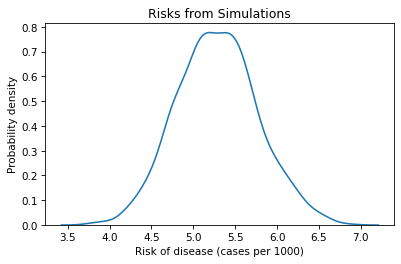

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(t, label='control')

plt.xlabel('Risk of disease (cases per 1000)')
plt.ylabel('Probability density')
plt.title('Risks from Simulations');

The mean of this distribution is about 5.3, which is close to the observed risk, as we should expect.

In [17]:
np.mean(t), risk_treatment

(5.284478654019068, 5.294144493633334)

The width of this distribution indicates how much variation there is in the estimate due to randomness.
One way to quantify the width of the distribution is the standard deviation.

In [18]:
standard_error = np.std(t)
standard_error

0.48237692869481597

This result is called the **standard error**.

Another way to quantify the width of the distribution is an interval between two percentiles.
For example, if we compute the 5th and 95th percentiles, the interval we get contains 90% of the simulated results.

In [19]:
confidence_interval = np.percentile(t, [5, 95])
confidence_interval

array([4.51827849, 6.11564967])

This result is called a **confidence interval**; specifically, this one is a "90% confidence interval", or 90% CI.
If we assume that the observed risk is correct, and we run the same trial many times, we expect 90% of the results to fall in this interval.

Standard errors and confidence intervals quantify our uncertainty about the estimate due to random variation from one trial to another.

## Simulating the Trial

In the previous section we simulated one group and estimated their risk.
Now we'll simulate both groups and estimate the efficacy of the vaccine.

The following function takes four parameters: the sizes of the two groups and their actual risks.

In [20]:
def simulate_trial(n1, p1, n2, p2):
    risk1 = simulate_group(n1, p1)
    risk2 = simulate_group(n2, p2)
    efficacy = 1 - risk2 / risk1
    return efficacy

If we call this function once, it simulates both groups, computes the risks in each group, and uses the results to compute the efficacy of the treatment (assuming that the first group is the control).

In [21]:
p1 = k_control / n_control
p2 = k_treatment / n_treatment
simulate_trial(n_control, p1, n_treatment, p2)

0.7022507535102278

If we call it many times, the result is a list of efficacies from multiple simulated trials.

In [22]:
t2 = [simulate_trial(n_control, p1, n_treatment, p2)
      for i in range(1001)]

We can use a KDE plot to visualize the distribution of the results.

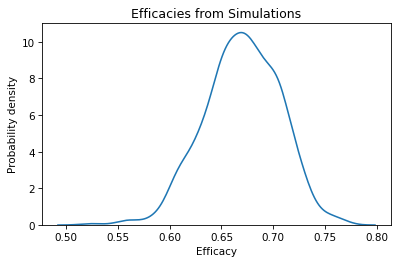

In [23]:
sns.kdeplot(t2)

plt.xlabel('Efficacy')
plt.ylabel('Probability density')
plt.title('Efficacies from Simulations');

The mean of this distribution is close to the efficacy we computed with the results of the actual trial.

In [24]:
np.mean(t2), efficacy

(0.6697923695446464, 0.6708455902182797)

The standard deviation of this distribution is the standard error of the estimate.

In [25]:
np.std(t2)

0.03654909244711291

In a scientific paper, we could report the estimated efficacy and standard error as 0.67 (SE 0.035).
As an alternative, we can use percentiles to compute a 90% confidence interval.

In [26]:
np.percentile(t2, [5, 95])

array([0.60861545, 0.7251222 ])

We could report these results as 0.67, 90% CI [0.61, 0.72].

The standard error and confidence interval represent nearly the same information.
In general, I prefer to report a confidence interval because it is easier to interpret:

* Formally, the confidence interval means that if we run the same experiment again, we expect 90% of the results to fall between 61% and 72% (assuming that the estimated risks are correct).

* More casually, it means that it is plausible that the actually efficacy is as low as 61%, or as high as 72% (assuming there are no sources of error other than random variation).

## Estimating Means

In the previous examples, we estimated risk, which is a proportion, and efficacy, which is a ratio of two proportions.
As a third example, let's estimate a mean.

Suppose we want to estimate the average height of men in the United States.
It would be impractical to measure everyone in the country, but if we choose a random sample of the population and measure the people in the sample, we can use the mean of the measurements to estimate the actual average in the population.

Ideally, the sample should be **representative**, which means that everyone in the population has an equal chance of appearing in the sample.
In general, that's not easy to do.
Depending on how you recruit people, your sample might have too many tall people or too many short people.

But let's suppose we have a representative sample of 103 adult male residents of the United States, the average height in the sample is 177 cm, and the standard deviation is 8.4 cm.

If someone asks for your best guess about the height of men in the U.S., you would report 177 cm.
But how accurate do you think this estimate is?
If you only measure 103 people from a population of about 100 million adult males, it seems like the actual average in the population might be substantially higher or lower.

Again, we can use random simulation to quantify the uncertainty of this estimate.
As we did in the previous examples, we'll assume for purposes of simulation that the estimates are correct, and simulate the sampling process many times.

The following function takes as parameters the size of the sample, `n`, the presumed average height in the population, `mu`, and the presumed standard deviation, `sigma`. 

In [27]:
def simulate_sample_mean(n, mu, sigma):
    sample = np.random.normal(mu, sigma, size=n)
    return sample.mean()

This function generates `n` random values from a normal distribution with the given mean and standard deviation, and returns their mean.
We can run it like this, using the observed mean and standard deviation from the sample as the presumed mean and standard deviation of the population.

In [28]:
n_height = 103
mean_height = 177
std_height = 8.4

simulate_sample_mean(n_height, mean_height, std_height)

177.0925279328183

If we run it many times, it simulates the sampling and measurement process and returns a list of results from many simulated experiments.

In [29]:
t3 = [simulate_sample_mean(n_height, mean_height, std_height)
      for i in range(1001)]

We can use a KDE plot to visualize the distribution of these values.

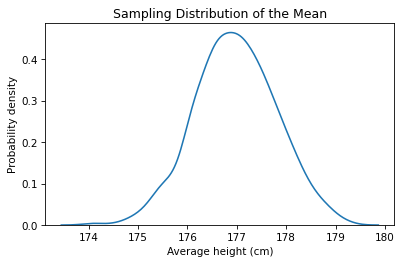

In [30]:
sns.kdeplot(t3)

plt.xlabel('Average height (cm)')
plt.ylabel('Probability density')
plt.title('Sampling Distribution of the Mean');

This result is called a **sampling distribution** because it represents the variation in the results due to the random sampling process.
If we recruit 103 people and compute the mean of their heights, the result might be as low as 176 cm, or as high as 180 cm, due to chance.

The average of the sampling distribution is close to the presumed mean of the population.

In [31]:
np.mean(t3), mean_height

(176.97693409905207, 177)

The standard deviation of the sampling distribution is the standard error of the estimate.

In [32]:
standard_error = np.std(t3)
standard_error

0.8255649832811274

The interval between the 5th and 95th percentiles is a 90% confidence interval.

In [33]:
ci90 = np.percentile(t3, [5, 95])
ci90

array([175.57572755, 178.34974372])

If I reported this result in a paper, I would say that the estimated height of adult male residents of the U.S. is 177 cm, 90% CI [176, 178] cm.

Informally, that means that the estimate could plausibly be off by about a centimeter either way, due to random sampling.
But we should remember that there are other possible sources of error, so we might be off by more than that.

## The Resampling Framework

The examples in this chapter fit into the framework shown in this diagram:

![](https://github.com/AllenDowney/ElementsOfDataScience/raw/v1/figs/resampling.png)

Using data from an experiment, we compute a sample statistic.  In the vaccine example, we computed risks for each group and efficacy.  In the height example, we computed the average height in the sample.

Then we build a model of the sampling process.
In the vaccine example, the model assumes that everyone in each group has the same probability of getting sick, and we use the data to choose the probability.
In the height example, the model assumes that heights are drawn from a normal distribution, and we use the data to choose the parameters `mu` and `sigma`.

We use the model to simulate the experiment many times. Each simulation generates a dataset which we use to compute the sample statistic.

Finally, we collect the sample statistics from the simulations, plot the sampling distribution, and compute standard error and a confidence interval.

I emphasize the role of the model in this framework because for a given experiment there might be several possible models, each including some elements of the real world and ignoring others.
For example, our model of the vaccine experiment assumes that everyone in each group has the same risk, but that's probably not true.
Here's another version of `simulate_group` that includes variation in risk within each group.

In [34]:
def simulate_variable_group(n, p):
    ps = np.random.uniform(0, 2*p, size=n)
    k = bernoulli.rvs(ps).sum()
    return k / n * 1000

This version of the function assumes that each person has a different probability of getting sick, drawn from a uniform distribution between `0` and `2*p`.
Of course, that's just a guess about how the probabilities might be distributed, but we can use it to get a sense of what effect this distribution has on the results.

The rest of the function is the same as the previous version: it uses `bernoulli` to simulate `n` patients, where each element of `ps` is the probability that one patient gets the disease.
Here's how we call this function, simulating the treatment group.

In [35]:
p = k_treatment / n_treatment
simulate_variable_group(n_treatment, p)

4.290082606909771

The return value is the number of cases per 1000.

**Exercise:** Use this function to run 1001 simulations of the treatment group.  Compute the mean of the results and confirm that it is close to the observed `risk_treatment`.  To quantify the spread of the sampling distribution, compute the standard error.  How does it compare to the standard error we computed with the original model, where everyone in the group has the same risk? 

In [36]:
# Solution

t4 = [simulate_variable_group(n_treatment, p)
      for i in range(1001)]

In [37]:
# Solution

np.mean(t4), risk_treatment

(5.300755563180829, 5.294144493633334)

In [38]:
# Solution

# The standard error is not substantially different 
# with the modified model. That's good news, because
# it suggests the result is not sensitive to the simplifying
# assumption that everyone has the same risk.

np.std(t4), np.std(t)

(0.46153761931912834, 0.48237692869481597)

**Exercise:** The following is a version of `simulate_trial` that uses `simulate_variable_group`, from the previous exercise, to simulate the vaccine trial using the modified model, which includes variation in risk within the groups.

Use this function to simulate 1001 trials. Compute the mean of the sampling distribution and confirm that it is close to the observed `efficacy`. Compute the standard error and compare it to the standard error we computed for the original model.

In [39]:
def simulate_variable_trial(n1, p1, n2, p2):
    risk1 = simulate_variable_group(n1, p1)
    risk2 = simulate_variable_group(n2, p2)
    efficacy = 1 - risk2 / risk1
    return efficacy

In [40]:
# Solution

p1 = k_control / n_control
p2 = k_treatment / n_treatment
simulate_variable_trial(n_control, p1, n_treatment, p2)

0.7142569965563594

In [41]:
# Solution

t5 = [simulate_variable_trial(n_control, p1, n_treatment, p2)
      for i in range(1001)]

In [42]:
# Solution

np.mean(t5), efficacy

(0.6677500708382919, 0.6708455902182797)

In [43]:
# Solution

# The standard error not substantially different with the modified model

np.std(t5), np.std(t2)

(0.03546017799198445, 0.03654909244711291)

**Exercise:** One nice thing about the resampling framework is that it is easy to compute the sampling distribution for other statistics.
For example, suppose we want to estimate the coefficient of variation (standard deviation as a fraction of the mean) for adult male height.  Here's how we can compute it.

In [44]:
cv = std_height / mean_height
cv

0.04745762711864407

In this example, the standard deviation is about 4.5% of the mean. 
The following is a version of `simulate_sample` that generates a random sample of heights and returns the coefficient of variation, rather than the mean. 

In [45]:
def simulate_sample_cv(n, mu, sigma):
    sample = np.random.normal(mu, sigma, size=n)
    return sample.std() / sample.mean()

Use this function to simulate 1001 samples with size `n=103`, using `mean_height` for `mu` and `std_height` for `sigma`.
Plot the sampling distribution of the coefficient of variation, and compute a 90% confidence interval.

In [46]:
# Solution

t6 = [simulate_sample_cv(n_height, mean_height, std_height)
      for i in range(1001)]

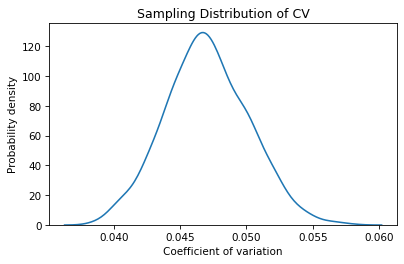

In [47]:
# Solution

sns.kdeplot(t6)

plt.xlabel('Coefficient of variation')
plt.ylabel('Probability density')
plt.title('Sampling Distribution of CV');

In [48]:
# Solution

np.percentile(t6, [5, 95])

array([0.04198156, 0.05233549])

## Summary

Let's review the examples in this chapter:

1. We started with results from a vaccine trial.  We estimated the effectiveness of the vaccine and used simulation to draw a random sample from the sampling distribution of effectiveness.  We used that sample to compute a standard error and a 90% confidence interval, which measure the variability we would expect if we ran the experiment again (assuming that the observed efficacy is correct).

2. As a second example, we estimated the height of adult males in the U.S. and used simulation based on a normal model to compute the sampling distribution of the mean, standard error, and a confidence interval.

3. We implemented a second model of the vaccine trial, based on the assumption that there is variation in risk within the groups. The results from the two models are similar, which suggests that the simple model is good enough for practical purposes.

4. One of the advantages of resampling, compared to mathematical analysis, is that it is easy to compute the sampling distribution of almost any statistic.  As an exercise, you computed the sampling distribution of the coefficient of variation.


*Elements of Data Science*

Copyright 2021 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)